# [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (TF2 version)

This notebook contains code to reproduce experiments and figures for the "Texture Generation with Neural Cellular Automata" article, using **TensorFlow 2**. We also provide a minimal **PyTorch** implementation [here](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb)

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title install selforg package
# install the package locally
!pip install -e git+https://github.com/google-research/self-organising-systems#egg=self_organising_systems --source-directory=.
# activate the locally installed package (otherwise a runtime restart is required)
import pkg_resources
pkg_resources.get_distribution("self_organising_systems").activate()

Obtaining self_organising_systems from git+https://github.com/google-research/self-organising-systems#egg=self_organising_systems
  Cloning https://github.com/google-research/self-organising-systems to ./self-organising-systems
  Running command git clone -q https://github.com/google-research/self-organising-systems /content/self-organising-systems
  Running setup.py develop for self-organising-systems


In [2]:
#@title imports & notebook utilities 
%tensorflow_version 2.x

!pip install --quiet ml_collections
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont 
import base64
import zipfile
import json
import requests
import random
import numpy as np
import matplotlib.pylab as pl
import glob
from concurrent.futures import ThreadPoolExecutor
from string import Template

import tensorflow as tf

from IPython.display import Image, HTML, clear_output, Javascript
from tqdm import tqdm_notebook

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

from ml_collections import ConfigDict

from self_organising_systems import texture_ca
from self_organising_systems.texture_ca.losses import StyleModel, Inception
from self_organising_systems.texture_ca.texture_synth import TextureSynthTrainer
from self_organising_systems.texture_ca import ca
from self_organising_systems.texture_ca.ca import to_rgb
from self_organising_systems.texture_ca.config import cfg
from self_organising_systems.shared.util import imread, imencode, imwrite, zoom, tile2d
from self_organising_systems.texture_ca.export_models import export_models_to_js


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

     |████████████████████████████████| 77 kB 1.2 MB/s 
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fe25c660-fc79-80c2-08aa-d132f4645a0b)


In [3]:
#@title config { run: "auto", vertical-output: true }
#@markdown The package makes use of a config dict to define aspects of the CA. 
#@markdown There are three options to modify these, check this box and run this cell, modify the `cfg` dict, or modify config.py in the package.
#@title Boolean fields
modify_config = False #@param {type:"boolean", run: "auto"}

# cellular automata parameters
import ipywidgets as widgets
from ipywidgets import Layout
widget_map ={
    str: widgets.Text,
    int: widgets.IntText,
    float: widgets.FloatText,
    bool: widgets.Checkbox
}

def render_cfg(cfg, prefix='cfg'):
  for key, value in cfg.items():
    if type(value) in widget_map:
      widget = widget_map[type(value)](description="%s.%s" % (prefix, key), value=value, style={'description_width': '40%'}, layout=Layout(width='80%'))  
      widget.observe(lambda x, key=key: cfg.update({key: x['new']}), names='value')
      display(widget)
    elif type(value) is ConfigDict:
      render_cfg(value, "%s.%s" % (prefix, key))
      
if modify_config:
  render_cfg(cfg)

In [4]:
#@title ⬅ run this cell to explore pretrained models! {vertical-output: true}
!wget -qnc --show-progress -i https://github.com/selforglive/selforg-assets/raw/main/texture-nca/model_npys.txt -B "https://github.com/selforglive/selforg-assets/raw/main/texture-nca/"
!cat model_npys.zip.bz2.part* > model_npys.zip.bz2
!bzip2 -dq model_npys.zip.bz2 > /dev/null 2>&1
pretrained_models = np.load('model_npys.zip',  allow_pickle=True)

model_groups = {}
for name in pretrained_models:
  g = name.split('_')[0]
  model_groups.setdefault(g, []).append(name)

@widgets.interact(group=model_groups)
def f(group):
  @widgets.interact(name=group)
  def g(name, with_video=True):
    if name == 'mondrian':
      display(HTML('This CA was tranied to immitate <a href="https://www.bukowskis.com/en/auctions/H042/96-franciska-clausen-contre-composition-composition-neoplasticiste-hommage-a-mondrian">the painting by Franciska Clausen</a>'))
    elif name.startswith('mixed'):
      display(HTML('This CA was trained to <a href="https://distill.pub/2017/feature-visualization/">activate a channel</a> of the pretrained Inception network.'))
    else:
      display(HTML('''Trained on a texture from the <a href="https://www.robots.ox.ac.uk/~vgg/data/dtd">DTD dataset</a>.<br>
        (Note that some thumbnails below mismatch the scale or content of the actual training image)'''))
      url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/%s/%s.jpg'%(name.split('_')[0], name)
      imshow(imread(url, cfg.texture_ca.vgg_input_img_size))
    draw_steps = [50, 250, 1000]
    print(name, 'at steps', draw_steps)
    f = ca.CAModel(pretrained_models[name]).embody()
    x = tf.zeros([1, 192, 192, cfg.texture_ca.channel_n])
    box = widgets.HBox()
    box.layout.flex_flow = 'wrap'
    display(box)
    frames = []
    for i in range(max(draw_steps)):
      x = f(x)
      img = to_rgb(x)[0]
      if i%5==0:
        frames.append(img)
      if i+1 in draw_steps:
        box.children += (widgets.Image(value=imencode(img)),)
    if with_video:
      with VideoWriter('t.mp4') as vid:
        for img in frames:
          vid.add(img)
      box.children += (widgets.Video(value=open('t.mp4', 'rb').read()),)
    


model_npys.txt      100%[===================>]      78  --.-KB/s    in 0s      
model_npys.zip.bz2. 100%[===================>]  50.00M   124MB/s    in 0.4s    
model_npys.zip.bz2. 100%[===================>]  50.00M   114MB/s    in 0.4s    
model_npys.zip.bz2. 100%[===================>]  23.65M  82.5MB/s    in 0.3s    


interactive(children=(Dropdown(description='group', options={'mondrian': ['mondrian'], 'banded': ['banded_0002…

# texture NCA

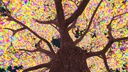

58900480/58889256 [==============================] - 2s 0us/step


In [5]:
#@title ⬅ run this cell to upload target texture image!

from google.colab import files

uploaded = files.upload()
texture_name = list(uploaded.keys())[0]
img_f = io.BytesIO(uploaded[texture_name])
img = imread(img_f, cfg.texture_ca.vgg_input_img_size, mode='RGB')
clear_output()
imshow(img)
imwrite('_target.png', img)

loss_model = StyleModel('_target.png')
out_fn = os.path.join(texture_name + '.npy')
trainer = TextureSynthTrainer(loss_model=loss_model)

In [6]:
#@title training loop {vertical-output: true}
#@markdown Run this cell a few times to train for more steps
try:
  for i in range(cfg.texture_ca.train_steps):
    r = trainer.train_step()
    if i%10 == 0:
      clear_output(True)
      pl.yscale('log')
      pl.plot(trainer.loss_log, '.', alpha=0.3)
      pl.show()
      vis = np.hstack(to_rgb(r.batch.x))
      imshow(vis)
      print('\r', len(trainer.loss_log), r.loss.numpy(), end='')
    if (i+1)%500 == 0:
      trainer.ca.save_params(out_fn)
except KeyboardInterrupt:
  pass
finally:
  trainer.ca.save_params(out_fn)
  print('\nsaved model as "%s"'%out_fn)





saved model as "tenere.jpg.npy"


# javascript demo

In [10]:
glob.glob('*.npy')

['tenere.jpg.npy']

In [13]:
js_models_str

'{"model_names": ["tenere.jpg.npy"], "layers": [{"scale": 1.2442430257797241, "data": "", "shape": [49, 96], "quant_scale_zero": [2.0, 0.0], "layout": [1, 1]}, {"scale": 0.6903610825538635, "data": "", "shape": [97, 12], "quant_scale_zero": [4.0, 0.4980392156862745], "layout": [1, 1]}]}'

In [11]:
#@title javascript demo {vertical-output: true}
#@markdown This demo allows to run .npy models from the current directory,
#@markdown or 50 randomly sampled pretrained models in the browser using WebGL.

# export local .npy files
models = {name:np.load(name, allow_pickle=True) for name in glob.glob('*.npy')}

js_models = export_models_to_js(models)
js_models_str = json.dumps(js_models)

display(HTML(Template('''
<script src="https://cdn.jsdelivr.net/npm/twgl.js@4.15.0/dist/4.x/twgl-full.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/dat.gui@0.7.7/build/dat.gui.min.js"></script>

<canvas width="512" height="512"></canvas>

<script type="module">
$ca_js
const models = $models_json;
const canvas = document.querySelector('canvas');
const gl = canvas.getContext("webgl");
const W=256, H=256;

const gui = new dat.GUI();
const param = {
  active: true,
  disturbance: false,
  clear_on_change: true,
  model: 0,
  zoom: 1.0
};
const name2idx = Object.fromEntries(models.model_names.map((s, i) => [s, i]));
gui.add(param, 'model').options(name2idx).listen().onChange(()=>{
  ca.paint(0, 0, 1000, param.model);
  if (param.clear_on_change)
    ca.clearCircle(0, 0, 1000);
});

gui.add(param, 'active');
gui.add(param, 'disturbance');
gui.add(param, 'clear_on_change');
gui.add(param, 'zoom', 1.0, 32.0);

const ca = new CA(gl, models, [W, H], gui);
ca.alignment = 0;

function render() {
  if (param.active) {
    if (param.disturbance) {
      const t = 2.0*Date.now()/1000.0;
      ca.clearCircle(Math.sin(t*2.0)*W/3+W/2, Math.cos(t*3.1)*H/3+H/2, 20);
    }
    ca.step();
  }
  twgl.bindFramebufferInfo(gl);
  ca.draw(param.zoom);
  requestAnimationFrame(render);  
}

requestAnimationFrame(render);
</script>
''').substitute(
    ca_js=open(texture_ca.__path__[0]+'/ca.js').read(),
    models_json=js_models_str
  )
))
